<a href="https://colab.research.google.com/github/hmehryar/Hm.JetscapeMl/blob/309-implementingtraining-pointnet-for-alpha_s-with-various-epochs-and-folds-and-finding-the-best-learning-rate/jet_ml_pointnet_alpha_s/jet_ml_pointnet_alpha_s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install --upgrade tensorflow
import tensorflow as tf

In [3]:
# uncomment this cell when you are on COLAB
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))
# # from google.colab import drive
# # drive.mount('/content/drive')

In [4]:
import sys
sys.path.insert(1,'/wsu/home/gy/gy40/gy4065/hm.jetscapeml.source')
sys.path.insert(1,'/content/drive/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.source')
sys.path.insert(1,'/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.source')
sys.path.insert(1,'/g/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.source')
sys.path.insert(1,'G:\\My Drive\\Projects\\110_JetscapeMl\\hm.jetscapeml.source')

In [5]:
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import set_directory_paths
dataset_directory_path, simulation_directory_path = set_directory_paths()


########################################################################
Checking the running platforms and setting the directory path

Python version: 3.11.5
OS: Windows
OS version: 10
running on Colab: False
Dataset Directory Path: D:\Projects\110_JetscapeMl\hm.jetscapeml.data\
Simulation Results Path: D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\
########################################################################



In [6]:
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import get_labels_str
label_str_dict=get_labels_str()

Aggregatring all parameters values
label_items:
 {'y_class_label_items': ['MMAT', 'MLBT'], 'alpha_s_items': [0.2, 0.3, 0.4], 'q0_items': [1.5, 2.0, 2.5]}
Building required params for the loading the dataset file
labels_str:
 {'class_labels_str': 'MMAT_MLBT', 'alpha_s_items_str': '0.2_0.3_0.4', 'q0_items_str': '1.5_2.0_2.5'}


In [7]:
with tf.device("CPU"):
    from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import get_dataset
    dataset_size=1000
    dataset_x, dataset_y=get_dataset(dataset_size,label_str_dict, dataset_directory_path,working_column=0,scale_x=True)

Loading the whole dataset
dataset.x: <class 'numpy.ndarray'> 1024000 (1000, 32, 32)
dataset.y: <class 'numpy.ndarray'> 3000 (1000, 3)
Scaling the datset_x each image between 0 and 1
Extract the working column#0 for classification
dataset.x: <class 'numpy.ndarray'> 1024000 (1000, 32, 32)
dataset.y: <class 'numpy.ndarray'> 1000 (1000,)
dataset.y(working_column) sample ['MLBT' 'MLBT' 'MLBT' 'MMAT' 'MMAT' 'MMAT' 'MMAT' 'MMAT' 'MLBT' 'MLBT']


In [8]:
with tf.device("CPU"):
    from jet_ml_models.pointnet import preprocess_dataset
    (x_train,  y_train,x_test,  y_test)=preprocess_dataset(dataset_x, dataset_y,is_one_hot_encoded=False)
    print("deleting original dataset")
    del dataset_x,dataset_y

Pre-processing
dataset_x_points shape: (1000, 1024, 3)
deleting the original dataset after splitting ...
train_points: <class 'numpy.ndarray'> 2457600 (800, 1024, 3)
train_y: <class 'numpy.ndarray'> 800 (800,)
x_test_points: <class 'numpy.ndarray'> 614400 (200, 1024, 3)
y_test: <class 'numpy.ndarray'> 200 (200,)
y_test[:10]:
 ['MMAT' 'MMAT' 'MMAT' 'MLBT' 'MLBT' 'MMAT' 'MMAT' 'MMAT' 'MLBT' 'MLBT']
Preprocess y_train and y_test
Encoding to sparse categorical variable
y_test_encoded:
 [1 1 1 0 0 1 1 1 0 0]
deleting original dataset


In [9]:
with tf.device("CPU"):
    from jet_ml_models.pointnet import create_tf_dataset
    print("converting to tensor data")
    # Create TensorFlow Dataset for training data and test data
    dataset = create_tf_dataset(x_train, y_train)
    test_dataset = create_tf_dataset(x_test, y_test)
    len_x_train=len(x_train)
    len_x_test=len(x_test)
    print("deleting preprocessed dataset")
    del x_train,y_train,x_test,y_test

converting to tensor data
deleting preprocessed dataset


In [10]:
from jet_ml_models.pointnet import prepare_datasets
from jet_ml_models.pointnet import augment

with tf.device("CPU"):
    # Prepare datasets for training
    print("going to prepare dataset")
    train_dataset, validation_dataset,test_dataset = prepare_datasets(dataset, test_dataset, len_x_train, len_x_test, augment,train_size=1)
    print("deleting initial tensor dataset")
    del dataset

going to prepare dataset
deleting initial tensor dataset


In [11]:
with tf.device("CPU"):
    print(len(test_dataset))
    print(len(validation_dataset))

7
7


In [12]:
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import generate_simulation_path
monitor = 'val_accuracy'  # 'val_accuracy' or 'val_loss'

classifying_parameter="eloss"
n_epochs = 100
fold = 1

current_simulation_path = generate_simulation_path(simulation_directory_path, classifying_parameter,label_str_dict, dataset_size, n_epochs, fold)
print("current_simulation_path:",current_simulation_path)

# Use ModelCheckpoint callback to save the best model
best_model_file_path = f'{current_simulation_path}_best_model.keras'
print("best_model_file_path:",best_model_file_path)

simulation_directory_path: D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\


KeyError: 'eloss_items_str'

In [12]:
from jet_ml_models.pointnet import build_pointnet_classifier_model

NUM_POINTS = 1024
#because alpha_s can get 3 values
NUM_CLASSES = 3
activation="softmax"
# activation="sigmoid"

pointnet=build_pointnet_classifier_model(NUM_POINTS=NUM_POINTS,NUM_CLASSES=NUM_CLASSES, activation=activation)


In [13]:
from jet_ml_models.pointnet import compile_pointnet_classifier_model_with_hyperparam
from jet_ml_models.pointnet import print_model_summary
learning_rate=0.001
loss='sparse_categorical_crossentropy'
# loss='categorical_crossentropy',

metrics='sparse_categorical_accuracy'
# metrics=['accuracy'],

pointnet=compile_pointnet_classifier_model_with_hyperparam(pointnet,learning_rate=learning_rate, loss=loss,metrics=metrics)
# print_model_summary(pointnet)

In [14]:
# %%timeit -n1 -r1
from jet_ml_models.pointnet import train_model_with_callbacks
monitor='val_sparse_categorical_accuracy'
with tf.device('/GPU:0'):
  model, history, train_time=train_model_with_callbacks(pointnet, train_dataset=train_dataset, validation_dataset=validation_dataset,monitor=monitor, best_model_file_path=best_model_file_path, n_epochs=n_epochs)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 58.4999 - sparse_categorical_accuracy: 0.3295
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.26500, saving model to D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_pointnet_classification_alpha_s_0.2_0.3_0.4_size_1000_epochs_100_fold_1_best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - loss: 58.1378 - sparse_categorical_accuracy: 0.3296 - val_loss: 272.0306 - val_sparse_categorical_accuracy: 0.2650
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 36.2211 - sparse_categorical_accuracy: 0.3205
Epoch 2: val_sparse_categorical_accuracy improved from 0.26500 to 0.34500, saving model to D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_pointnet_classification_alpha_s_0.2_0.3_0.4_size_1000_epochs_100_fold_1_best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - loss: 36.2098 - sparse_categorical_accuracy: 0.3206 - val_loss: 49.1218 - val_sparse_categorical

In [15]:
print(train_time)
print(model)
print(history.history)

9.495279304186504
<Functional name=pointnet, built=True>
{'loss': [49.08642578125, 35.9262809753418, 35.4564208984375, 35.31743621826172, 35.28157043457031, 35.23838424682617, 35.207088470458984, 35.125797271728516, 35.1102409362793, 35.14894104003906, 35.14856719970703, 35.102088928222656, 35.114871978759766, 35.109012603759766, 35.12224197387695, 35.10212707519531, 35.113826751708984], 'sparse_categorical_accuracy': [0.33125001192092896, 0.32374998927116394, 0.3362500071525574, 0.3400000035762787, 0.3499999940395355, 0.35874998569488525, 0.3487499952316284, 0.36375001072883606, 0.36125001311302185, 0.35374999046325684, 0.32374998927116394, 0.3675000071525574, 0.3512499928474426, 0.33500000834465027, 0.3449999988079071, 0.3487499952316284, 0.3487499952316284], 'val_loss': [272.0306396484375, 49.121761322021484, 34.38341522216797, 34.37838363647461, 34.01335144042969, 33.828697204589844, 33.94624328613281, 34.22758865356445, 33.7921028137207, 33.82533645629883, 34.12158966064453, 34.15

In [16]:
from jet_ml_models.pointnet import save_training_history
training_history_file_path_json,training_history_file_path_csv,training_history_file_path_csv = \
  save_training_history(history,current_simulation_path)

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_pointnet_classification_alpha_s_0.2_0.3_0.4_size_1000_epochs_100_fold_1_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_pointnet_classification_alpha_s_0.2_0.3_0.4_size_1000_epochs_100_fold_1_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_pointnet_classification_alpha_s_0.2_0.3_0.4_size_1000_epochs_100_fold_1_training_history.npy


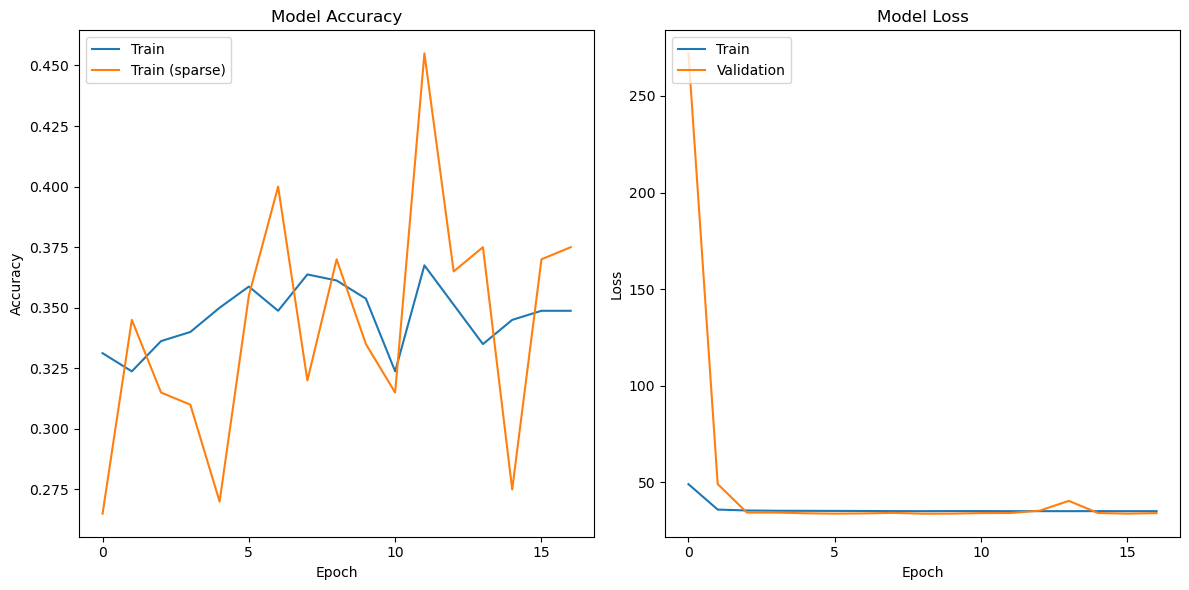

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_pointnet_classification_alpha_s_0.2_0.3_0.4_size_1000_epochs_100_fold_1_accuracy_loss.png


In [17]:
from jet_ml_models.pointnet import plot_training_history
plot_training_history_path=plot_training_history(history,current_simulation_path)
print(plot_training_history_path)

In [18]:
from jet_ml_models.pointnet import evaluate_model
accuracy, confusion_matrix = evaluate_model(model,test_dataset=test_dataset)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 558ms/step
Accuracy: 0.405
Confusion Matrix: [[40  4 34]
 [31  6 22]
 [23  5 35]]


In [19]:
from jet_ml_models.pointnet import save_kfold_results
results_kfold = []
results_kfold.append({
                  'Dataset Size': dataset_size,
                  'Classifier': model.name,
                  'Fold Number': fold,
                  'Accuracy': accuracy,
                  'Confusion Matrix': confusion_matrix,
                  'Train Time': train_time,
                  'Loss/Accuracy Plot Path': plot_training_history_path,
                  'Best Model Path': best_model_file_path
              })
save_kfold_results(results_kfold, current_simulation_path)

   Dataset Size Classifier  Fold Number  Accuracy  \
0          1000   pointnet            1     0.405   

                          Confusion Matrix  Train Time  \
0  [[40, 4, 34], [31, 6, 22], [23, 5, 35]]    9.495279   

                             Loss/Accuracy Plot Path  \
0  D:\Projects\110_JetscapeMl\hm.jetscapeml.data\...   

                                     Best Model Path  
0  D:\Projects\110_JetscapeMl\hm.jetscapeml.data\...  


Dataset Size Classifier  Fold Number  Accuracy  \
0          1000   pointnet            1     0.405   

                          Confusion Matrix  Train Time  \
0  [[40, 4, 34], [31, 6, 22], [23, 5, 35]]    9.495279   

                             Loss/Accuracy Plot Path  \
0  D:\Projects\110_JetscapeMl\hm.jetscapeml.data\...   

                                     Best Model Path  
0  D:\Projects\110_JetscapeMl\hm.jetscapeml.data\...